# Making money with RNN (!)
<br/>
<center><img src="img/bitcoin_price.png"><em>Bitcoin price</em></center>

In this tutorial, we will train a RNN that is for predicting bitcoin price. If one of you get sucess on this tutorial, please share your precious implementation tips for me :)

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

import torch.nn as nn
import torch

In [2]:
res = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1446300800&end=9999999999999&period=86400')

df = pd.DataFrame(res.json())
df.to_csv('bitcoin_price.csv')

## How the dataset looks like?

One record $x_{t}$ contains 8 features (date, high, low, open, close, volume, quotoVolume, weightedAvg.).
In this tutorial, we will use one feature, __close__ (종가), as the input of RNN. The objective of this tutorial is to predict future __close__ values.

In [3]:
df.head(5) # Display 5 records (rows) from the top

close        date      high       low      open    quoteVolume  \
0  0.001302  1446300800  0.001302  0.001302  0.001302       0.000000   
1  0.001300  1446336000  0.001373  0.001270  0.001294   51907.796794   
2  0.001234  1446422400  0.001330  0.001200  0.001300   89174.287725   
3  0.001110  1446508800  0.001242  0.001068  0.001231  135380.492024   
4  0.001248  1446595200  0.001248  0.001025  0.001097  152791.666598   

       volume  weightedAverage  
0    0.000000         0.001302  
1   68.322124         0.001316  
2  110.507220         0.001239  
3  154.564774         0.001142  
4  169.865786         0.001112

In [4]:
y_data = list(df['close'])

In [5]:
target_seq = y_data
seq_len = 30

In [6]:
X =[target_seq[i: i+seq_len] for i in range(0,len(target_seq))][:-seq_len]
Y =[target_seq[i: i+seq_len] for i in range(1,len(target_seq))][:-seq_len]

In [7]:
X = torch.Tensor(X).reshape(-1, seq_len, 1).float()
Y = torch.Tensor(Y).reshape(-1, seq_len, 1).float()

In [8]:
xs = [X[i][0].detach().numpy() for i in range(X.size(0))]
ys = [Y[i][0].detach().numpy() for i in range(Y.size(0))]

In [9]:
num_train_set = math.floor(X.shape[0] * 0.8)

X_train = X[:num_train_set,:, :]
Y_train = Y[:num_train_set, :, :]

X_test = X[num_train_set:,:, :]
Y_test = Y[num_train_set:,:, :]

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def init_hiddens(self, batch_size, device=None):
        
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
        if device is not None:
          hidden = hidden.to(device)
          cell = cell.to(device)
        
        return hidden, cell
    
    def forward(self, x, hidden=None, cell=None, device=None):
        if hidden is None and cell is None:
            batch_size = x.size(0)
            hidden, cell = self.init_hiddens(batch_size, device)
        
        out, (hidden, cell) = self.rnn(x, (hidden, cell))
        out = self.fc(out)
        return out, hidden, cell
    
    def rollout(self, x_inits, x_start,  n_rollouts=100, device=None):
        _, hidden, cell = self.forward(x_inits, device)
        
        traj = []
        for i in range(n_rollouts):
            x, hidden, cell = self.forward(x, hidden, cell, device)
            traj.append(x.detach().numpy().squeeze())
        return traj            

In [11]:
model = LSTM(input_size=1, output_size=1, hidden_dim=200, n_layers=2)
loss_fn = nn.MSELoss()
n_epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
def train(X_train, Y_train, n_epochs, lr, print_every=100, device=None):
    for epoch in range(n_epochs):
        losses = []
        output, hidden, cell = model(X_train, device=device)
        optimizer.zero_grad()
        loss = loss_fn(output, Y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % print_every == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {}".format(np.array(losses).mean()))

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
model.to(device)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [15]:
train(X_train, Y_train, 2000, lr, device=device)

Epoch: 0/2000............. Loss: 0.0011126158060505986
Epoch: 100/2000............. Loss: 6.967000081203878e-05
Epoch: 200/2000............. Loss: 3.1436808058060706e-05
Epoch: 300/2000............. Loss: 9.307637810707092e-06
Epoch: 400/2000............. Loss: 7.211737283796538e-06
Epoch: 500/2000............. Loss: 5.732984391215723e-06
Epoch: 600/2000............. Loss: 4.685090061684605e-06
Epoch: 700/2000............. Loss: 4.0369586713495664e-06
Epoch: 800/2000............. Loss: 3.5811499401461333e-06
Epoch: 900/2000............. Loss: 3.235746817153995e-06
Epoch: 1000/2000............. Loss: 2.8713579922623467e-06
Epoch: 1100/2000............. Loss: 2.737876002356643e-06
Epoch: 1200/2000............. Loss: 2.333995780645637e-06
Epoch: 1300/2000............. Loss: 2.099532139254734e-06
Epoch: 1400/2000............. Loss: 1.8848824083761428e-06
Epoch: 1500/2000............. Loss: 1.7486679553258e-06
Epoch: 1600/2000............. Loss: 1.5167395304160891e-06
Epoch: 1700/2000......

In [16]:
y_preds, hidden, cell = model.forward(X_test, device=device)

y_hat = [y_pred[-1,:].squeeze().detach().cpu().numpy() for y_pred in y_preds]
y_truth = [y_train[-1,:].squeeze().detach().cpu().numpy() for y_train in Y_test]

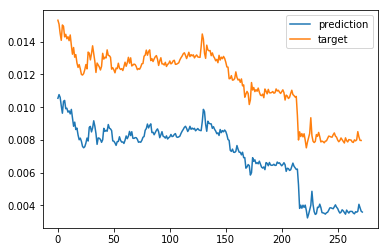

In [17]:
plt.plot(y_hat, label='prediction')
plt.plot(y_truth, label='target')
plt.legend()

In [18]:
model.to('cpu')
X_test = X_test.to('cpu')
Y_test = Y_test.to('cpu')

In [19]:
n_inits = 50
rollout_targets = y_data[n_inits:]
x_init = torch.Tensor(rollout_targets[:n_inits]).reshape(1, n_inits, 1)

n_rollouts = 500

x_init = x_init.reshape(1,-1,1)
x = torch.Tensor((rollout_targets[n_inits],)).reshape(1,1,1)
y = rollout_targets[n_inits: n_inits+n_rollouts]

out, hidden, cell = model(x_init)
traj = []
for i in range(n_rollouts):
    x, hidden, cell = model.forward(x, hidden, cell)
    traj.append(x.detach().numpy().squeeze())

In [20]:
plt.plot(traj, label='rollout')
plt.plot(y, label='truth')
plt.legend()